In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset : ISIC Challenge Dataset (Medical Image Segmentation on Skin Lesion Dermascopy)

Dataset: https://challenge.isic-archive.com/data/

For initial exploration, we will be working with the 2016 ISIC Challenge Dataset.

In [ ]:
# import utils
import sys

import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
import cv2
import albumentations as A

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [ ]:
dataset_basepath = "/content/drive/MyDrive/Assignments/06: FA25: CMPE-258 Sec 34 - Deep Learning/CMPE258-Project/Dataset/"

In [ ]:
# get the training data and ground truth paths from the dataset_basepath
train_data_path = Path(dataset_basepath + "ISBI2016_ISIC_Part1_Training_Data/ISBI2016_ISIC_Part1_Training_Data/")
train_gt_path = Path(dataset_basepath + "ISBI2016_ISIC_Part1_Training_GroundTruth/ISBI2016_ISIC_Part1_Training_GroundTruth/")
# get the testing data and ground truth paths from the dataset_basepath
test_data_path = Path(dataset_basepath + "ISBI2016_ISIC_Part1_Test_Data/ISBI2016_ISIC_Part1_Test_Data/")
test_gt_path = Path(dataset_basepath + "ISBI2016_ISIC_Part1_Test_GroundTruth/ISBI2016_ISIC_Part1_Test_GroundTruth/")

For this 2016 data, the training data is the image while the ground truth is the segmentation mask

In [ ]:
# create a train test val split on the data in the train and train_masks directory
train_size = 0.80
val_size = 0.20

In [ ]:
from torch.utils.data import Dataset # Ensure Dataset is imported from torch.utils.data

class ISIC_Dataset(Dataset):
  def __init__(self, img_dir, mask_dir, transform=None):
    self.transform = transform
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    # Get filenames and sort them to ensure corresponding image and mask pairs
    self.image_filenames = sorted(os.listdir(img_dir))
    self.mask_filenames = sorted(os.listdir(mask_dir))

    # Optional: Basic check for matching number of images and masks
    if len(self.image_filenames) != len(self.mask_filenames):
        print(f"Warning: Number of images ({len(self.image_filenames)}) does not match number of masks ({len(self.mask_filenames)})")

  def __len__(self):
    return len(self.image_filenames)

  def __getitem__(self, index):
    # Load the image and mask filenames for the current index
    img_name = self.image_filenames[index]
    mask_name = self.mask_filenames[index]

    # Construct full paths
    img_path = os.path.join(self.img_dir, img_name)
    mask_path = os.path.join(self.mask_dir, mask_name)

    # Open images using PIL
    image = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L') # Convert mask to grayscale

    if self.transform:
      image = self.transform(image)
      mask = self.transform(mask)

      image = ((image - image.min()) / (image.max() - image.min()))

    return image, mask

In [ ]:
# Define the augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [ ]:
train_set = ISIC_Dataset(img_dir = train_data_path,
                         mask_dir = train_gt_path,
                         transform=transform)

In [ ]:
test_set = ISIC_Dataset(img_dir = test_data_path,
                        mask_dir = test_gt_path,
                        transform=transform)

In [ ]:
# create a split on the dataset to create a train, val, and test set
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

In [ ]:
# check if data set was split correctly. Splits: Use 80% train / 20% val
len(train_dataset)/len(train_set), len(val_dataset)/len(train_set),

print(f"Train dataset size: {len(train_dataset)}/{len(train_set)}")
print(f"Validation dataset size: {len(val_dataset)}/{len(train_set)}")

# print as percentages
print(f"Train dataset size: {len(train_dataset)/len(train_set)*100}%")
print(f"Validation dataset size: {len(val_dataset)/len(train_set)*100}%")

Train dataset size: 720/900
Validation dataset size: 180/900
Train dataset size: 80.0%
Validation dataset size: 20.0%


In [ ]:
# Visualize a grid of (image, mask) pairs in the train dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage

def load_image(image_path):
  return Image.open(image_path).convert('RGB')

def load_mask(mask_path):
  return Image.open(mask_path).convert('L')

def show_image(image):
  return ToPILImage()(image)

In [ ]:
def visualize_data(dataset, num_rows=4, fig_size=8):
  fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(fig_size, fig_size))
  title = ["Image", "Mask"]
  for i in range(2):
    axes[0, i].set_title(title[i])

  for i in range(num_rows):
    img, mask = dataset[i]
    img = img.permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy()
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(mask, cmap='gray')
  plt.tight_layout(pad=0.01, h_pad=0.1)
  plt.show()

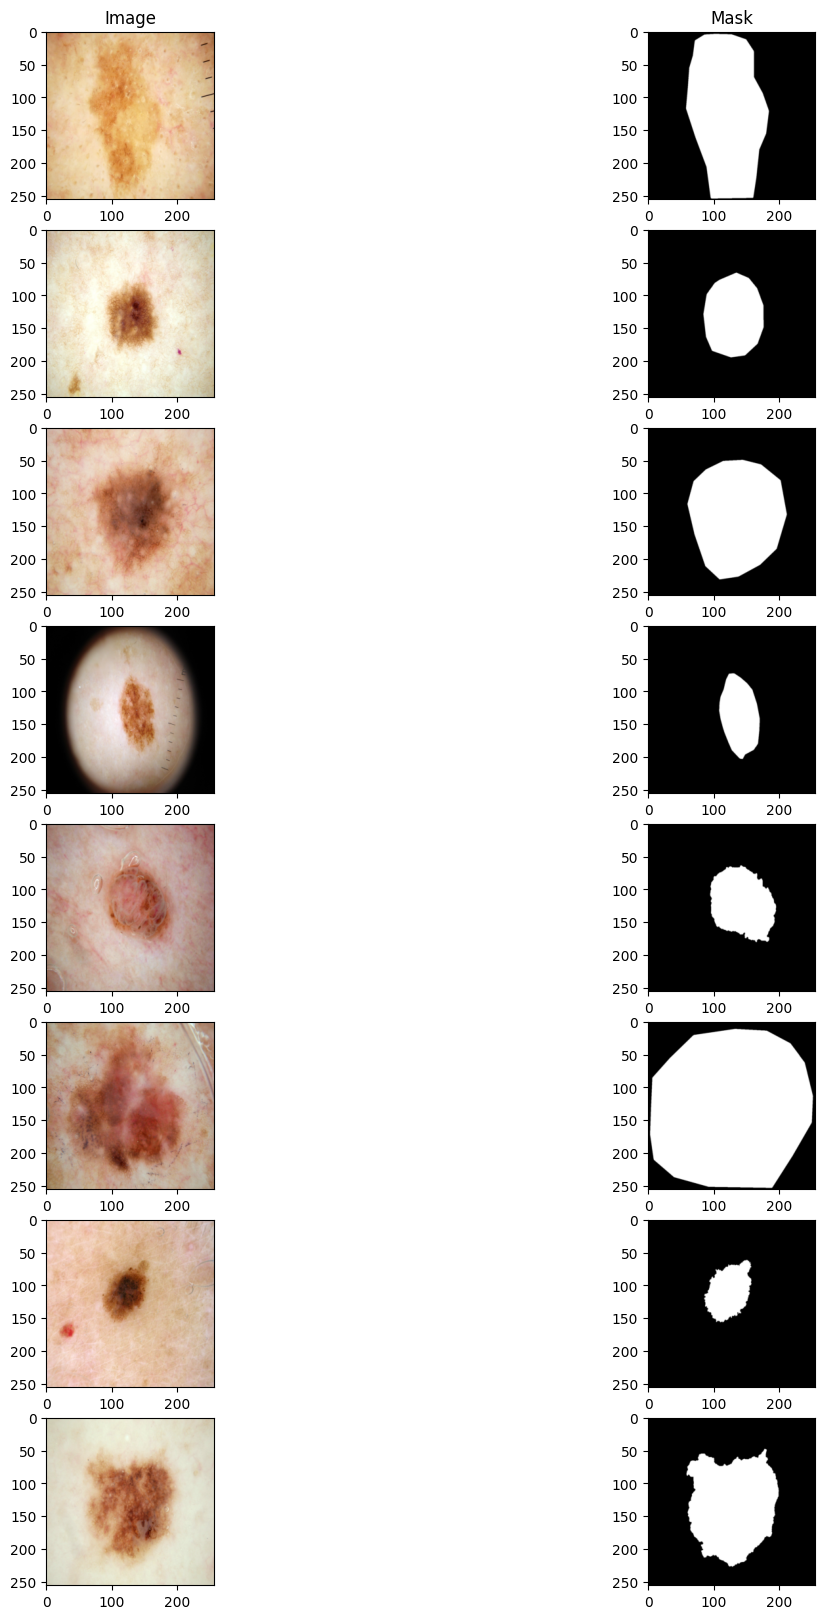

In [ ]:
visualize_data(train_dataset, num_rows=8, fig_size=16)

# Training
Create the unet model to train

In [ ]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    num_workers = torch.cuda.device_count() * 4

In [ ]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 8

train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_set,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)

    return dice

In [ ]:
torch.cuda.empty_cache()

In [ ]:
EPOCHS = 40

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0

    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)
        optimizer.zero_grad()

        # # Ensure mask has the same dimensions as y_pred for loss calculation
        # mask = mask.unsqueeze(1) # Add a channel dimension

        dc = dice_coefficient(y_pred, mask)
        loss = criterion(y_pred, mask)

        train_running_loss += loss.item()
        train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)

    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0

    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            # Ensure mask has the same dimensions as y_pred for loss calculation
            # mask = mask.unsqueeze(1) # Add a channel dimension

            loss = criterion(y_pred, mask)
            dc = dice_coefficient(y_pred, mask)

            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)

    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)


  2%|▎         | 1/40 [00:43<28:17, 43.53s/it]

------------------------------
Training Loss EPOCH 1: 0.5341
Training DICE EPOCH 1: 0.0284


Validation Loss EPOCH 1: 0.4844
Validation DICE EPOCH 1: 0.6340
------------------------------


  5%|▌         | 2/40 [01:29<28:34, 45.11s/it]

------------------------------
Training Loss EPOCH 2: 0.4053
Training DICE EPOCH 2: 0.6572


Validation Loss EPOCH 2: 0.4065
Validation DICE EPOCH 2: 0.6656
------------------------------


  8%|▊         | 3/40 [02:17<28:34, 46.34s/it]

------------------------------
Training Loss EPOCH 3: 0.3593
Training DICE EPOCH 3: 0.6974


Validation Loss EPOCH 3: 0.3838
Validation DICE EPOCH 3: 0.6839
------------------------------


 10%|█         | 4/40 [03:04<27:57, 46.59s/it]

------------------------------
Training Loss EPOCH 4: 0.3522
Training DICE EPOCH 4: 0.7050


Validation Loss EPOCH 4: 0.3856
Validation DICE EPOCH 4: 0.6677
------------------------------


 12%|█▎        | 5/40 [03:51<27:11, 46.62s/it]

------------------------------
Training Loss EPOCH 5: 0.2896
Training DICE EPOCH 5: 0.7783


Validation Loss EPOCH 5: 0.3139
Validation DICE EPOCH 5: 0.7766
------------------------------


 15%|█▌        | 6/40 [04:38<26:27, 46.69s/it]

------------------------------
Training Loss EPOCH 6: 0.2547
Training DICE EPOCH 6: 0.8135


Validation Loss EPOCH 6: 0.2574
Validation DICE EPOCH 6: 0.8383
------------------------------


 18%|█▊        | 7/40 [05:25<25:45, 46.84s/it]

------------------------------
Training Loss EPOCH 7: 0.2325
Training DICE EPOCH 7: 0.8346


Validation Loss EPOCH 7: 0.2401
Validation DICE EPOCH 7: 0.8474
------------------------------


 20%|██        | 8/40 [06:12<25:00, 46.90s/it]

------------------------------
Training Loss EPOCH 8: 0.2090
Training DICE EPOCH 8: 0.8449


Validation Loss EPOCH 8: 0.2214
Validation DICE EPOCH 8: 0.8549
------------------------------


 22%|██▎       | 9/40 [06:58<24:11, 46.83s/it]

------------------------------
Training Loss EPOCH 9: 0.2029
Training DICE EPOCH 9: 0.8469


Validation Loss EPOCH 9: 0.2234
Validation DICE EPOCH 9: 0.8564
------------------------------


 25%|██▌       | 10/40 [07:46<23:27, 46.93s/it]

------------------------------
Training Loss EPOCH 10: 0.1898
Training DICE EPOCH 10: 0.8556


Validation Loss EPOCH 10: 0.1975
Validation DICE EPOCH 10: 0.8784
------------------------------


 28%|██▊       | 11/40 [08:33<22:42, 46.98s/it]

------------------------------
Training Loss EPOCH 11: 0.1798
Training DICE EPOCH 11: 0.8641


Validation Loss EPOCH 11: 0.2072
Validation DICE EPOCH 11: 0.8685
------------------------------


 30%|███       | 12/40 [09:20<21:54, 46.96s/it]

------------------------------
Training Loss EPOCH 12: 0.1642
Training DICE EPOCH 12: 0.8734


Validation Loss EPOCH 12: 0.1872
Validation DICE EPOCH 12: 0.8813
------------------------------


 32%|███▎      | 13/40 [10:06<21:06, 46.91s/it]

------------------------------
Training Loss EPOCH 13: 0.1562
Training DICE EPOCH 13: 0.8790


Validation Loss EPOCH 13: 0.1798
Validation DICE EPOCH 13: 0.8900
------------------------------


 35%|███▌      | 14/40 [10:53<20:18, 46.86s/it]

------------------------------
Training Loss EPOCH 14: 0.1673
Training DICE EPOCH 14: 0.8703


Validation Loss EPOCH 14: 0.1989
Validation DICE EPOCH 14: 0.8761
------------------------------


 38%|███▊      | 15/40 [11:40<19:29, 46.79s/it]

------------------------------
Training Loss EPOCH 15: 0.1503
Training DICE EPOCH 15: 0.8833


Validation Loss EPOCH 15: 0.1881
Validation DICE EPOCH 15: 0.8749
------------------------------


 40%|████      | 16/40 [12:27<18:45, 46.91s/it]

------------------------------
Training Loss EPOCH 16: 0.1446
Training DICE EPOCH 16: 0.8868


Validation Loss EPOCH 16: 0.1766
Validation DICE EPOCH 16: 0.8830
------------------------------


 42%|████▎     | 17/40 [13:14<18:02, 47.05s/it]

------------------------------
Training Loss EPOCH 17: 0.1374
Training DICE EPOCH 17: 0.8919


Validation Loss EPOCH 17: 0.1760
Validation DICE EPOCH 17: 0.8872
------------------------------


 45%|████▌     | 18/40 [14:02<17:17, 47.15s/it]

------------------------------
Training Loss EPOCH 18: 0.1573
Training DICE EPOCH 18: 0.8773


Validation Loss EPOCH 18: 0.1855
Validation DICE EPOCH 18: 0.8801
------------------------------


 48%|████▊     | 19/40 [14:49<16:29, 47.14s/it]

------------------------------
Training Loss EPOCH 19: 0.1402
Training DICE EPOCH 19: 0.8892


Validation Loss EPOCH 19: 0.1570
Validation DICE EPOCH 19: 0.8973
------------------------------


 50%|█████     | 20/40 [15:36<15:42, 47.14s/it]

------------------------------
Training Loss EPOCH 20: 0.1335
Training DICE EPOCH 20: 0.8958


Validation Loss EPOCH 20: 0.2189
Validation DICE EPOCH 20: 0.8847
------------------------------


 52%|█████▎    | 21/40 [16:23<14:56, 47.19s/it]

------------------------------
Training Loss EPOCH 21: 0.1356
Training DICE EPOCH 21: 0.8926


Validation Loss EPOCH 21: 0.1469
Validation DICE EPOCH 21: 0.9010
------------------------------


 55%|█████▌    | 22/40 [17:10<14:07, 47.07s/it]

------------------------------
Training Loss EPOCH 22: 0.1250
Training DICE EPOCH 22: 0.9018


Validation Loss EPOCH 22: 0.1726
Validation DICE EPOCH 22: 0.8897
------------------------------


 57%|█████▊    | 23/40 [17:57<13:19, 47.04s/it]

------------------------------
Training Loss EPOCH 23: 0.1252
Training DICE EPOCH 23: 0.9030


Validation Loss EPOCH 23: 0.1550
Validation DICE EPOCH 23: 0.8984
------------------------------


 60%|██████    | 24/40 [18:45<12:36, 47.26s/it]

------------------------------
Training Loss EPOCH 24: 0.1147
Training DICE EPOCH 24: 0.9105


Validation Loss EPOCH 24: 0.1582
Validation DICE EPOCH 24: 0.8934
------------------------------


 62%|██████▎   | 25/40 [19:32<11:48, 47.25s/it]

------------------------------
Training Loss EPOCH 25: 0.1188
Training DICE EPOCH 25: 0.9051


Validation Loss EPOCH 25: 0.1481
Validation DICE EPOCH 25: 0.9043
------------------------------


 65%|██████▌   | 26/40 [20:19<11:01, 47.25s/it]

------------------------------
Training Loss EPOCH 26: 0.1085
Training DICE EPOCH 26: 0.9129


Validation Loss EPOCH 26: 0.1921
Validation DICE EPOCH 26: 0.8914
------------------------------


 68%|██████▊   | 27/40 [21:06<10:13, 47.19s/it]

------------------------------
Training Loss EPOCH 27: 0.1105
Training DICE EPOCH 27: 0.9087


Validation Loss EPOCH 27: 0.1537
Validation DICE EPOCH 27: 0.8981
------------------------------


 70%|███████   | 28/40 [21:53<09:25, 47.13s/it]

------------------------------
Training Loss EPOCH 28: 0.1066
Training DICE EPOCH 28: 0.9146


Validation Loss EPOCH 28: 0.1691
Validation DICE EPOCH 28: 0.8872
------------------------------


 72%|███████▎  | 29/40 [22:40<08:37, 47.01s/it]

------------------------------
Training Loss EPOCH 29: 0.1166
Training DICE EPOCH 29: 0.9051


Validation Loss EPOCH 29: 0.1489
Validation DICE EPOCH 29: 0.9040
------------------------------


 75%|███████▌  | 30/40 [23:27<07:50, 47.07s/it]

------------------------------
Training Loss EPOCH 30: 0.1106
Training DICE EPOCH 30: 0.9127


Validation Loss EPOCH 30: 0.1385
Validation DICE EPOCH 30: 0.9093
------------------------------


 78%|███████▊  | 31/40 [24:14<07:03, 47.06s/it]

------------------------------
Training Loss EPOCH 31: 0.1021
Training DICE EPOCH 31: 0.9179


Validation Loss EPOCH 31: 0.1501
Validation DICE EPOCH 31: 0.9058
------------------------------


 80%|████████  | 32/40 [25:01<06:16, 47.08s/it]

------------------------------
Training Loss EPOCH 32: 0.0895
Training DICE EPOCH 32: 0.9269


Validation Loss EPOCH 32: 0.1526
Validation DICE EPOCH 32: 0.9040
------------------------------


 82%|████████▎ | 33/40 [25:48<05:28, 46.92s/it]

------------------------------
Training Loss EPOCH 33: 0.0982
Training DICE EPOCH 33: 0.9199


Validation Loss EPOCH 33: 0.1383
Validation DICE EPOCH 33: 0.9050
------------------------------


 85%|████████▌ | 34/40 [26:35<04:42, 47.02s/it]

------------------------------
Training Loss EPOCH 34: 0.1006
Training DICE EPOCH 34: 0.9197


Validation Loss EPOCH 34: 0.1437
Validation DICE EPOCH 34: 0.9082
------------------------------


 88%|████████▊ | 35/40 [27:22<03:54, 46.95s/it]

------------------------------
Training Loss EPOCH 35: 0.0878
Training DICE EPOCH 35: 0.9273


Validation Loss EPOCH 35: 0.1740
Validation DICE EPOCH 35: 0.9024
------------------------------


 90%|█████████ | 36/40 [28:09<03:07, 46.99s/it]

------------------------------
Training Loss EPOCH 36: 0.0850
Training DICE EPOCH 36: 0.9292


Validation Loss EPOCH 36: 0.1617
Validation DICE EPOCH 36: 0.9050
------------------------------


 92%|█████████▎| 37/40 [28:56<02:21, 47.07s/it]

------------------------------
Training Loss EPOCH 37: 0.0809
Training DICE EPOCH 37: 0.9315


Validation Loss EPOCH 37: 0.1894
Validation DICE EPOCH 37: 0.9020
------------------------------


 95%|█████████▌| 38/40 [29:43<01:34, 47.11s/it]

------------------------------
Training Loss EPOCH 38: 0.0759
Training DICE EPOCH 38: 0.9376


Validation Loss EPOCH 38: 0.1801
Validation DICE EPOCH 38: 0.9080
------------------------------


 98%|█████████▊| 39/40 [30:31<00:47, 47.19s/it]

------------------------------
Training Loss EPOCH 39: 0.0712
Training DICE EPOCH 39: 0.9391


Validation Loss EPOCH 39: 0.1784
Validation DICE EPOCH 39: 0.9057
------------------------------


100%|██████████| 40/40 [31:18<00:00, 46.96s/it]

------------------------------
Training Loss EPOCH 40: 0.0685
Training DICE EPOCH 40: 0.9410


Validation Loss EPOCH 40: 0.2049
Validation DICE EPOCH 40: 0.8963
------------------------------


In [ ]:
# Saving the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Assignments/06: FA25: CMPE-258 Sec 34 - Deep Learning/CMPE258-Project/Code/checkpoints/shabab_isic_checkpoint_11_10_2025.pth')

In [ ]:
# load the model weights
model.load_state_dict(torch.load('/content/drive/MyDrive/Assignments/06: FA25: CMPE-258 Sec 34 - Deep Learning/CMPE258-Project/Code/checkpoints/shabab_isic_checkpoint_11_10_2025.pth'))

<All keys matched successfully>

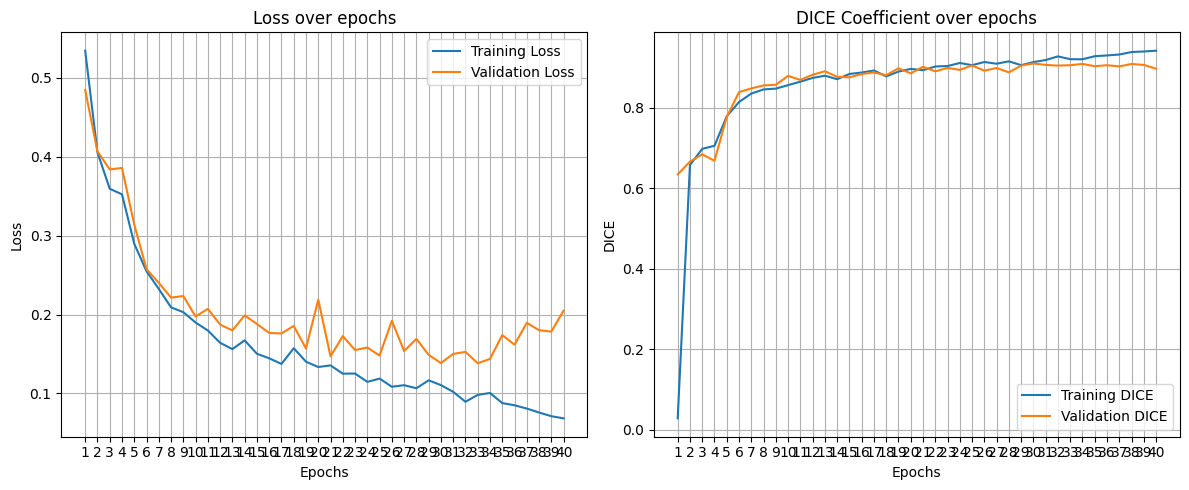

In [ ]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

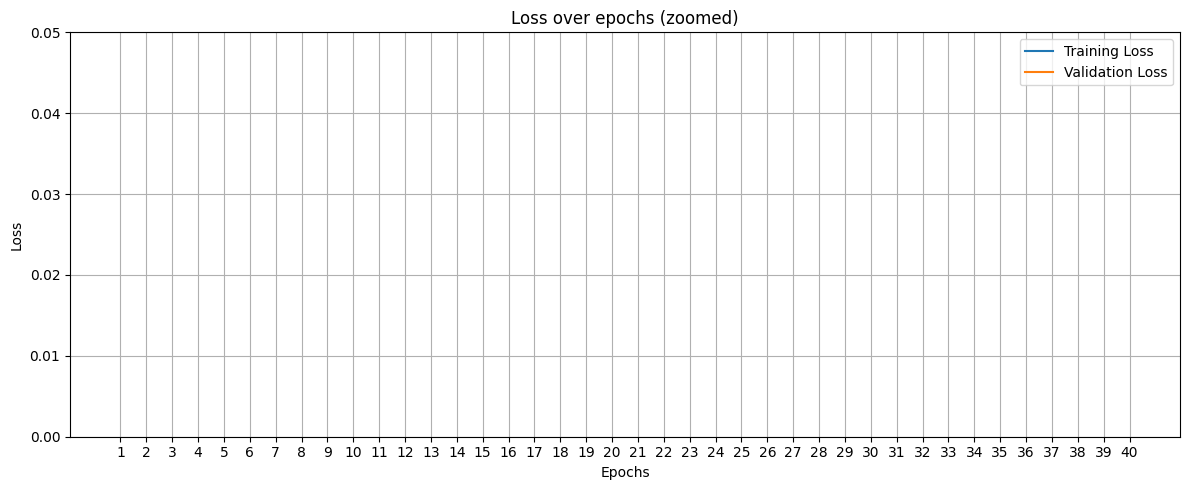

In [ ]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.ylim(0, 0.05)
plt.title('Loss over epochs (zoomed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()
plt.show()

# Evaluation

In [ ]:
model_pth = '/content/drive/MyDrive/Assignments/06: FA25: CMPE-258 Sec 34 - Deep Learning/CMPE258-Project/Code/checkpoints/shabab_isic_checkpoint_11_10_2025.pth'
trained_model = UNet(in_channels=3, num_classes=1).to(device)
trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
def jaccard_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1
    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    jaccard = (intersection + epsilon) / (union + epsilon)

    return jaccard

In [ ]:
test_running_loss = 0
test_running_dc = 0
test_running_jc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = criterion(y_pred, mask)
        dc = dice_coefficient(y_pred, mask)
        jc = jaccard_coefficient(y_pred, mask)


        test_running_loss += loss.item()
        test_running_dc += dc.item()
        test_running_jc += jc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)
    test_jc = test_running_jc / (idx + 1)

    print("-" * 30)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test DICE: {test_dc:.4f}")
    print(f"Test Jaccard: {test_jc:.4f}")
    print("-" * 30)

100%|██████████| 48/48 [01:15<00:00,  1.58s/it]

------------------------------
Test Loss: 0.1783
Test DICE: 0.8998
Test Jaccard: 0.4499
------------------------------


In [ ]:
def random_images_inference(image_tensors, mask_tensors, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((512, 512))
    ])

    predictions = []
    test_images = []
    mask_images = []

    test_dice = []
    test_jaccard = []

    # Iterate for the images, masks and paths
    for image_pth, mask_pth in zip(image_tensors, mask_tensors):
        # Load the image
        img = transform(image_pth)

        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)

        # Load the mask to compare
        mask = transform(mask_pth).permute(1, 2, 0).to(device)

        # print(f"Image: {os.path.basename(image_paths)}, DICE coefficient: {round(float(dice_coefficient(pred_mask, mask)),5)}")
        curr_test_dice = round(float(dice_coefficient(pred_mask, mask)),5)
        test_dice.append(curr_test_dice)
        curr_test_jaccard = round(float(jaccard_coefficient(pred_mask, mask)),5)
        test_jaccard.append(curr_test_jaccard)
        print(f"DICE coefficient: {curr_test_dice}")
        print(f"Jaccard coefficient: {curr_test_jaccard}")


        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1

        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("original")
        plt.subplot(132), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.subplot(133), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.show()

        predictions.append(pred_mask)
        test_images.append(img)
        mask_images.append(mask)

    return predictions, test_images, mask_images, test_dice, test_jaccard



In [ ]:
n = 10

image_tensors = []
mask_tensors = []
# image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])
    mask_tensors.append(random_sample[1])
    # image_paths.append(random_sample[2])

/tmp/ipython-input-1988734001.py:29: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  curr_test_dice = round(float(dice_coefficient(pred_mask, mask)),5)


DICE coefficient: 0.96513
Jaccard coefficient: 0.48256


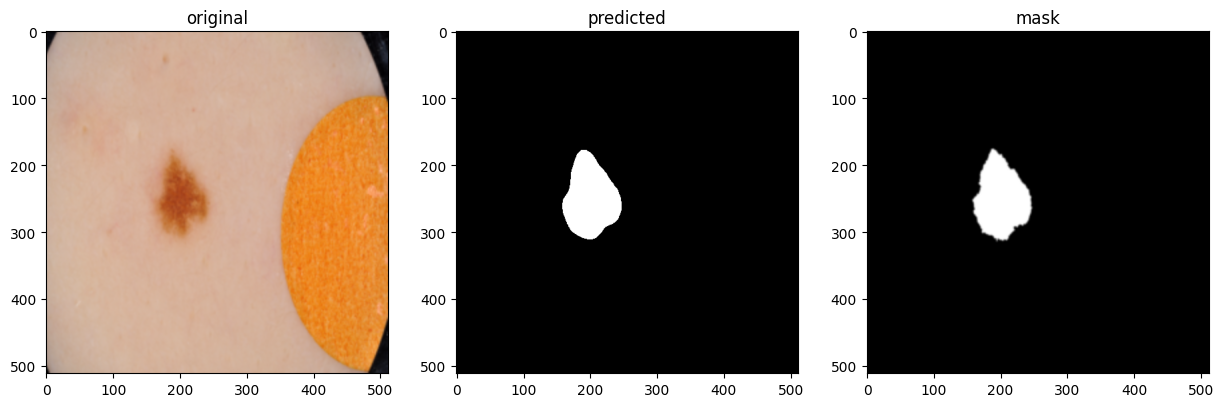

DICE coefficient: 0.89079
Jaccard coefficient: 0.4454


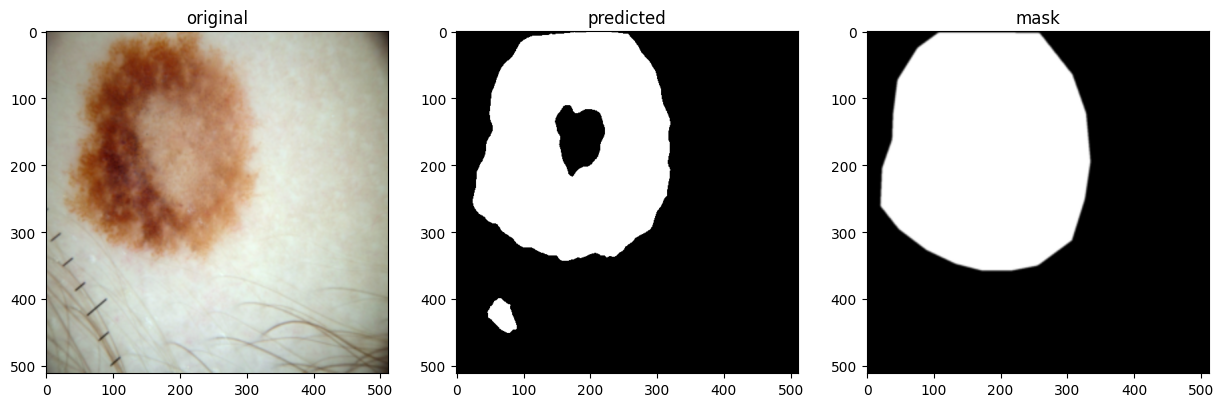

DICE coefficient: 0.88148
Jaccard coefficient: 0.44074


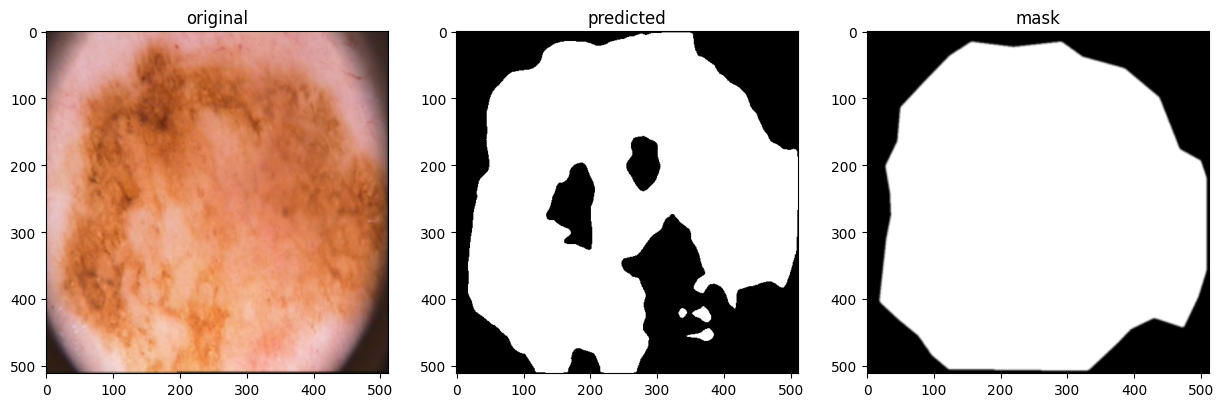

DICE coefficient: 0.94252
Jaccard coefficient: 0.47126


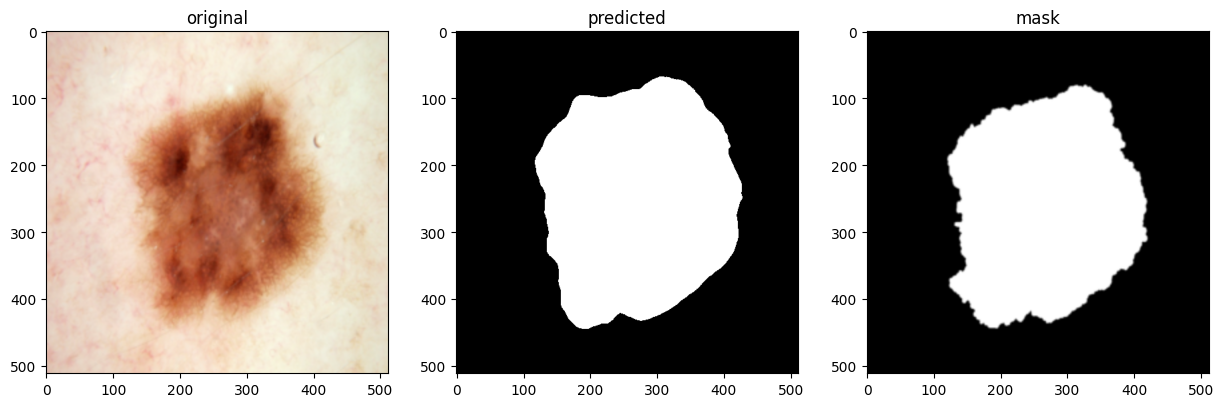

DICE coefficient: 0.96038
Jaccard coefficient: 0.48019


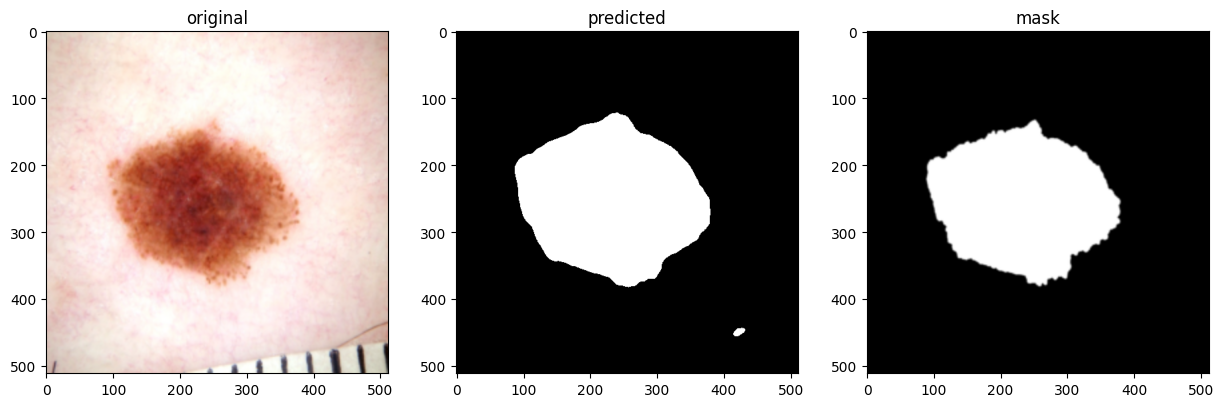

DICE coefficient: 0.95243
Jaccard coefficient: 0.47622


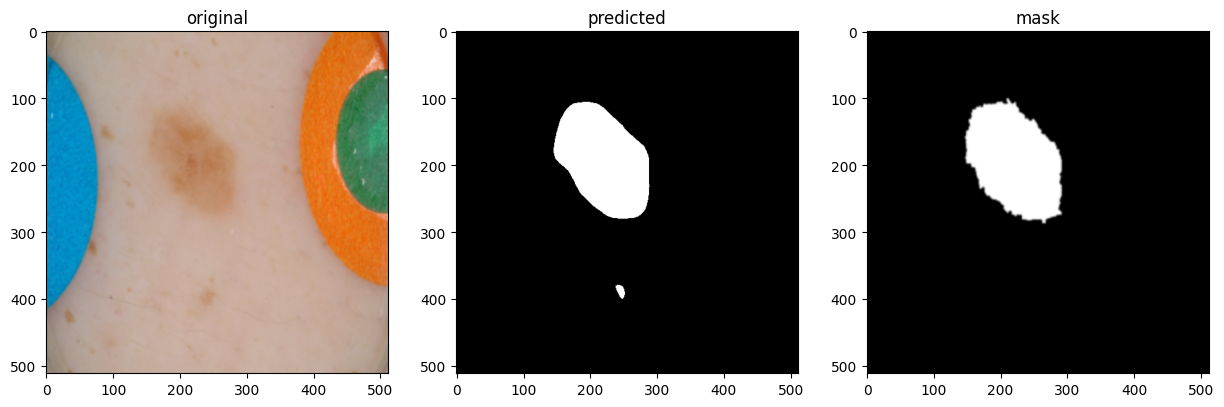

DICE coefficient: 0.80844
Jaccard coefficient: 0.40422


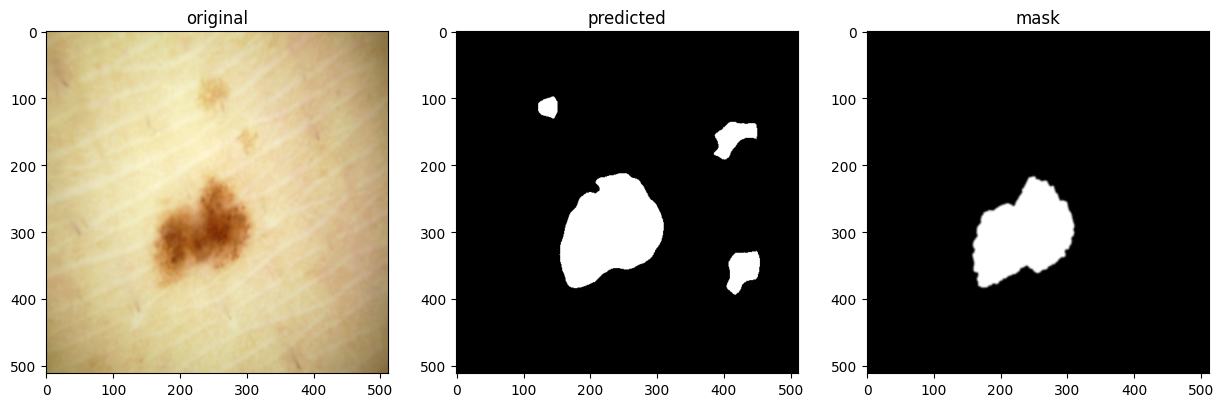

DICE coefficient: 0.94367
Jaccard coefficient: 0.47184


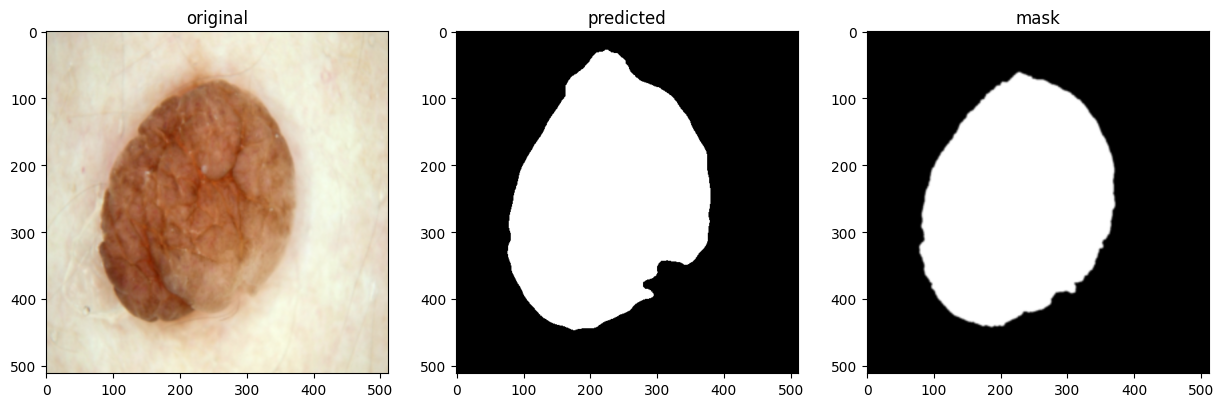

DICE coefficient: 0.85418
Jaccard coefficient: 0.42709


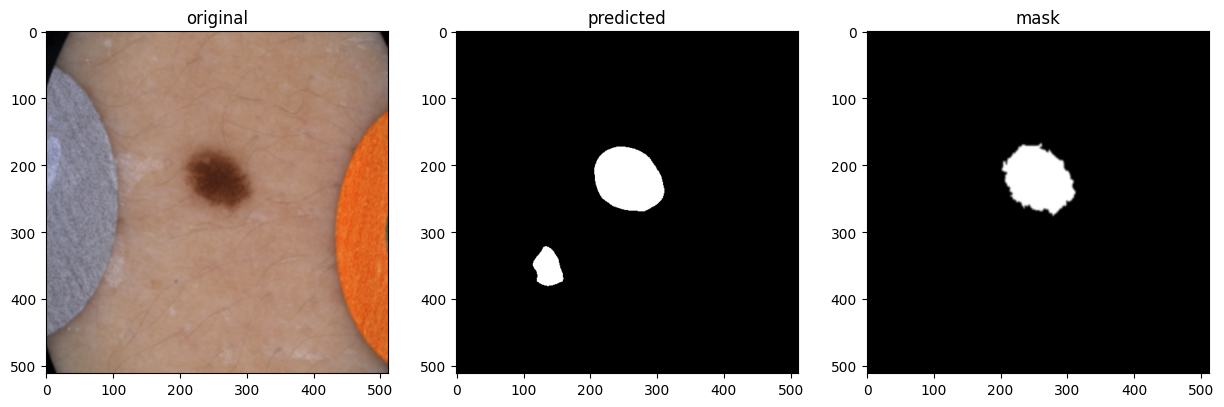

DICE coefficient: 0.95435
Jaccard coefficient: 0.47717


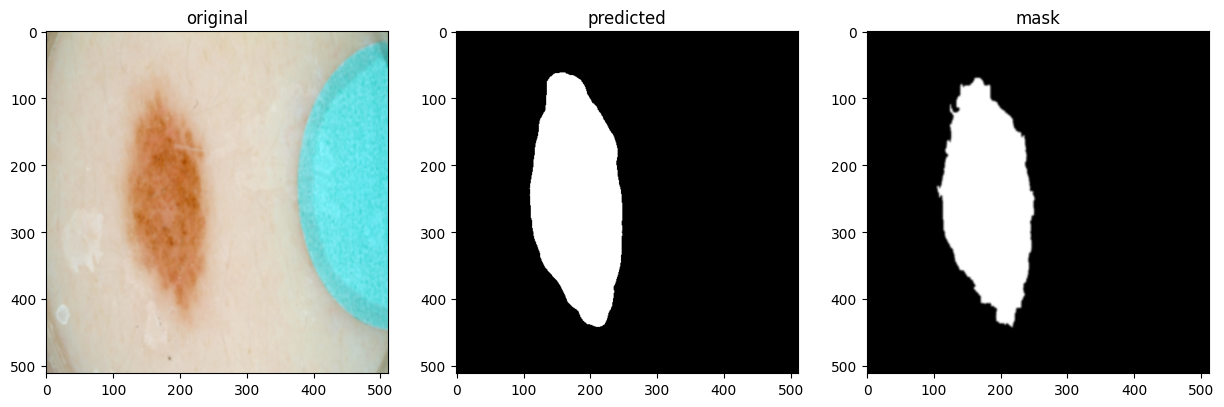

In [ ]:
model_path = '/content/drive/MyDrive/Assignments/06: FA25: CMPE-258 Sec 34 - Deep Learning/CMPE258-Project/Code/checkpoints/shabab_isic_checkpoint_11_10_2025.pth'
predictions, test_images, mask_images, test_dice, test_jaccard = random_images_inference(image_tensors, mask_tensors, model_path, device="cpu")

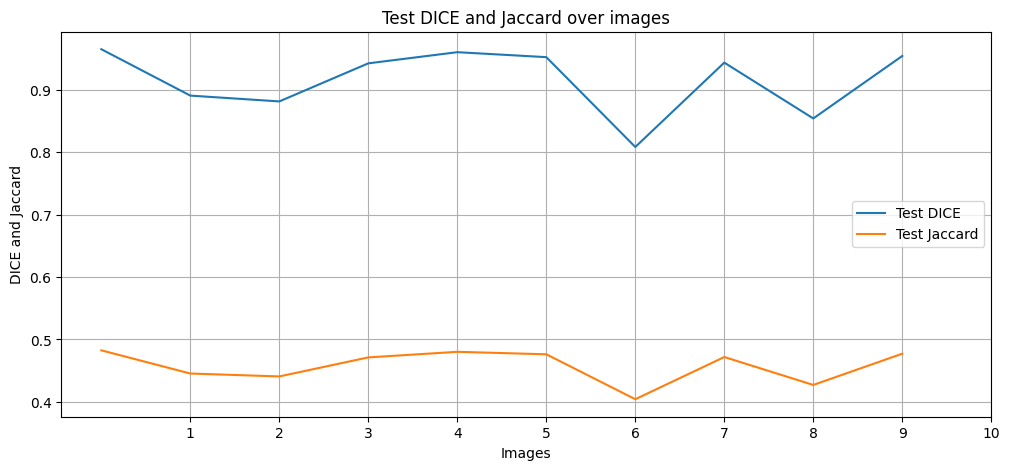

In [ ]:
# plot the test dice and jaccard values
plt.figure(figsize=(12, 5))
plt.plot(test_dice, label='Test DICE')
plt.plot(test_jaccard, label='Test Jaccard')
plt.xticks(ticks=list(range(1, n + 1, 1)))
plt.title('Test DICE and Jaccard over images')
plt.xlabel('Images')
plt.ylabel('DICE and Jaccard')
plt.grid()
plt.legend()
plt.show()

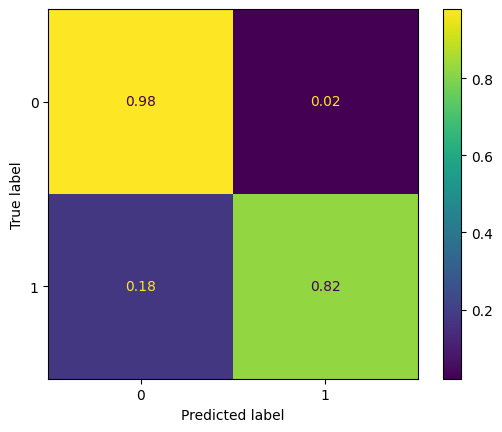

In [ ]:

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay


flat_preds = np.concatenate(predictions).flatten()
flat_truth = np.concatenate(mask_images).flatten()
# Binarize flat_truth to match flat_preds (0 or 1)
flat_truth = (flat_truth > 0.5).astype(int)

OUTPUT_CHANNELS = 2 # For binary classification (car vs background), there are 2 classes
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')